# **임대주택 단지 내 적정 주차수요 예측 대회**

처음부터 다시 시작하겠습니다.

In [1]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [2]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoLars, HuberRegressor

In [4]:
from pycaret.regression import *

In [5]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

In [6]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [7]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [8]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [9]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [10]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()), '지하철']) = 0

### Bus

In [11]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 지도를 확인한 결과 보수적으로 잡아도 7개 이상

train.loc[train['버스'].isnull(), '버스'] = 7

### Rent

In [12]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [13]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [14]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

# INVESTIGATION

- 전면 재수사에 돌입하겠습니다.
- 정황파악(BA&DA) -> 가설설정 -> 증거수집(EDA) -> 추가 증거수집(DEEP EDA) -> 증거 조합 -> 인사이트 체포

아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게되어 있어, 정확한 ②장래주차수요의 산정을 필요로 합니다.
현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로하여 산출되고 있으며, ‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사하고 있습니다.
이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없습니다.

정황파악은 어느정도 됐고...증거수집을 제대로 해봐야겠는데

In [15]:
train_apart = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                     '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[train['임대건물구분'] == '아파트']

train_shop = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                    '전용면적별세대수', '자격유형']].loc[train['임대건물구분'] == '상가']

train_danji = train[['단지코드', '총세대수', '지역', '공가수', '지하철',
                     '버스', '단지내주차면수', '등록차량수']].drop_duplicates()

test_apart = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형',
                   '임대보증금', '임대료']].loc[test['임대건물구분'] == '아파트']

test_shop = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수',
                  '자격유형']].loc[test['임대건물구분'] == '상가']

test_danji = test[['단지코드', '총세대수', '지역', '공가수', '지하철',
                   '버스', '단지내주차면수']].drop_duplicates()

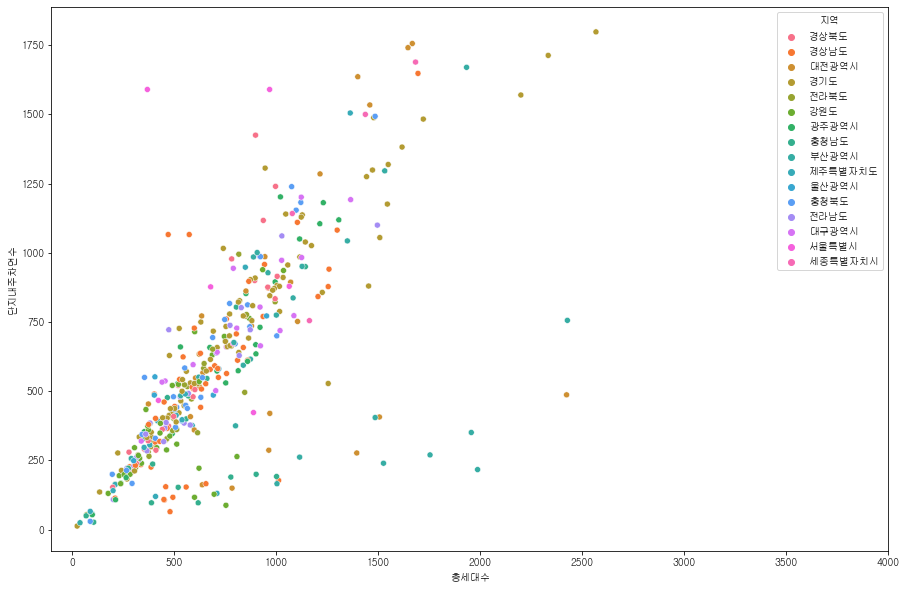

In [16]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=train_danji, x='총세대수', y='단지내주차면수', hue='지역')
plt.xlim(right=4000)
plt.show()

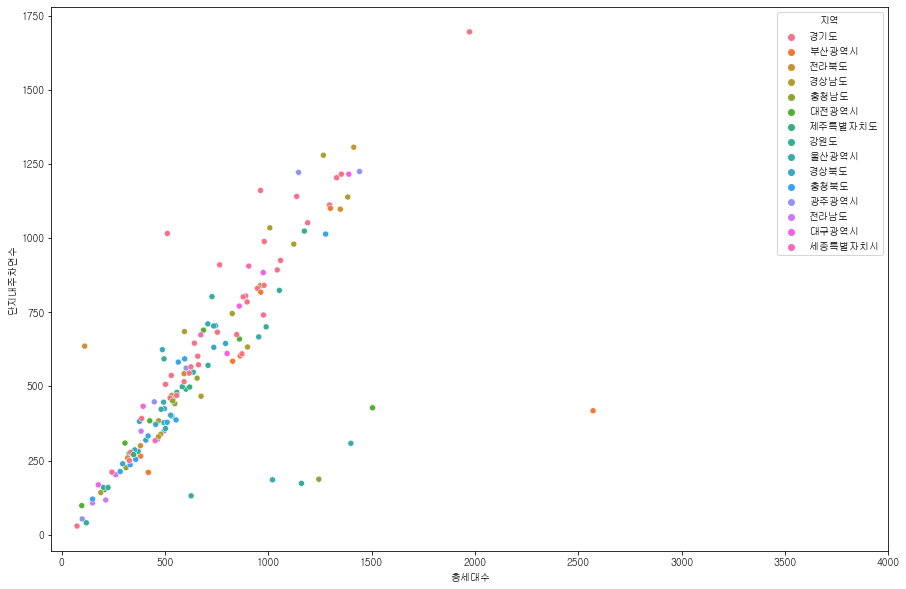

In [17]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=test_danji, x='총세대수', y='단지내주차면수', hue='지역')
plt.xlim(right=4000)
plt.show()

- 이게 말이 되나? 세대수가 100개 남짓인데 주차면수가 600개인 곳이 있고
- 세대수가 2500호가 넘는데 주차면수가 400 남짓이다? 이게 상식적으로 말이 되나?
- 법정 주차대수가 존재하기 때문에 최소한의 미니멈 주차면수가 있어야 하는데, 이게 말이 되나?

건축연면적을 따져봅시다.

In [18]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [19]:
temp = train.groupby(['단지코드']).sum().reset_index()
train_size = pd.merge(train_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

In [20]:
temp = test.groupby(['단지코드']).sum().reset_index()
test_size = pd.merge(test_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

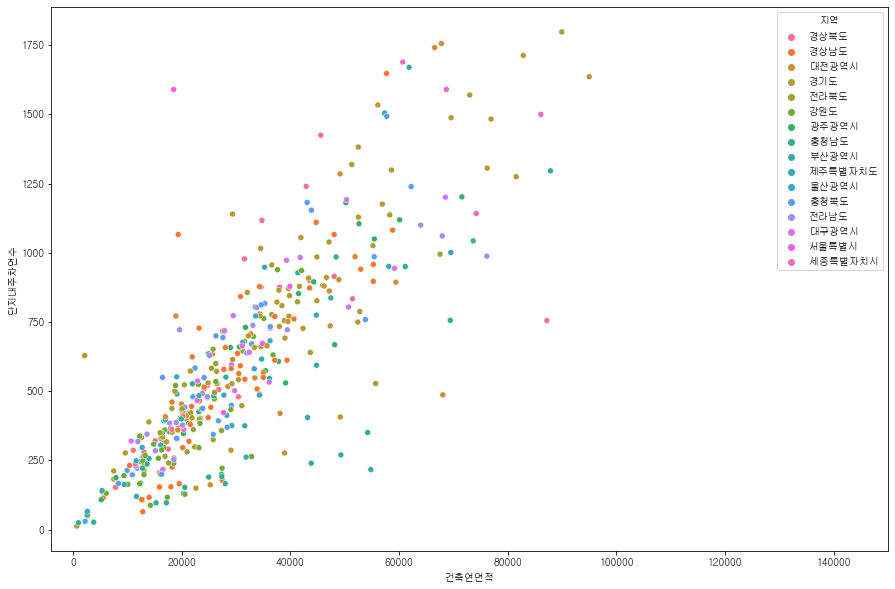

In [21]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=train_size, x='건축연면적', y='단지내주차면수', hue='지역')
plt.xlim(right=150000)
plt.show()

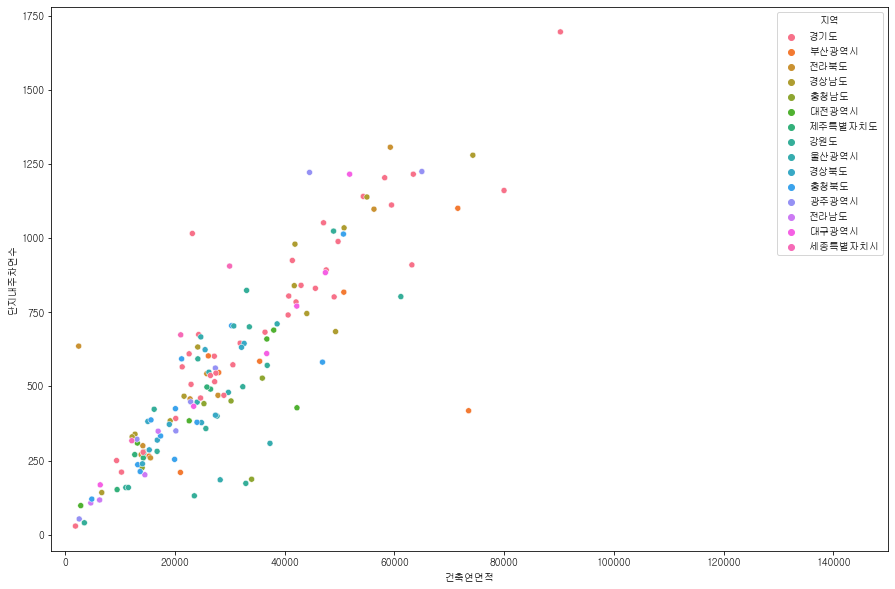

In [22]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=test_size, x='건축연면적', y='단지내주차면수', hue='지역')
plt.xlim(right=150000)
plt.show()

건축연면적으로 따져도 추세선을 벗어나는 단지가 몇 개 있습니다.

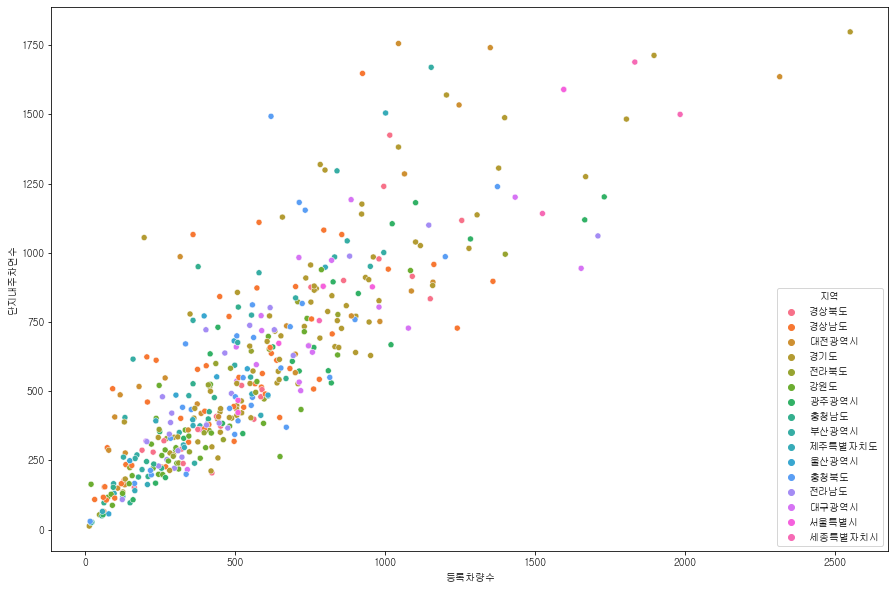

In [23]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=train_danji, x='등록차량수', y='단지내주차면수', hue='지역')
plt.show()

지역별로 살펴봐야겠습니다. 지역별로 법정주차대수가 다르기 때문에 그래프가 다르게 나타날 수 있습니다.

In [24]:
train_danji.head()

,단지코드,총세대수,지역,공가수,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0
8,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0
15,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0
26,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0
32,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0


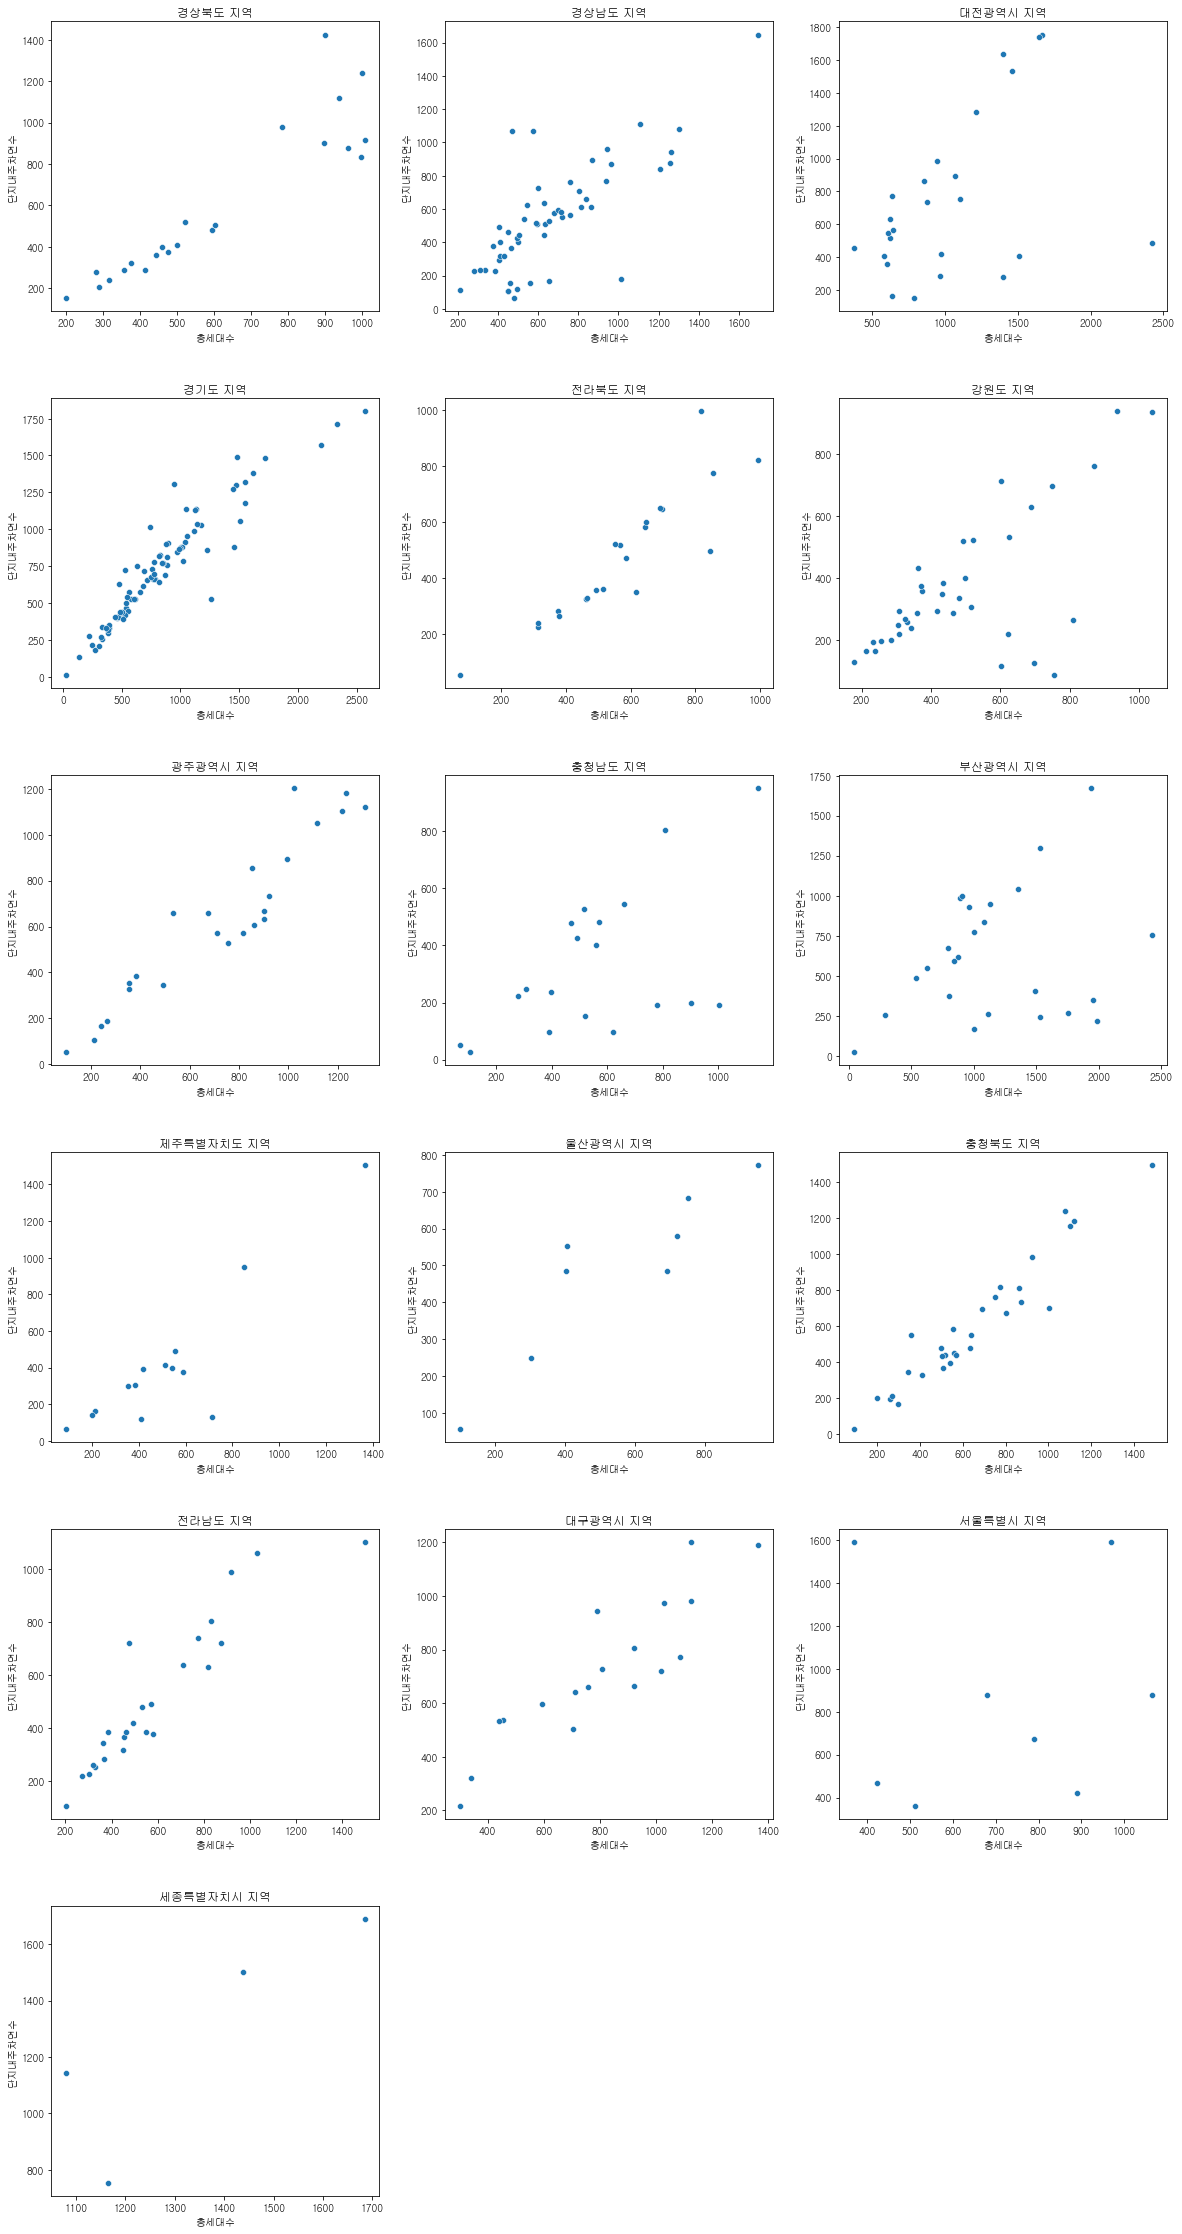

In [25]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.scatterplot(data=train_danji.loc[train_danji['지역'] == n], x='총세대수', y='단지내주차면수')
    plt.title('{} 지역'.format(n))

- 경기도, 광주, 전남, 충북, 대구, 전북 을 제외하고서는 중구난방입니다...

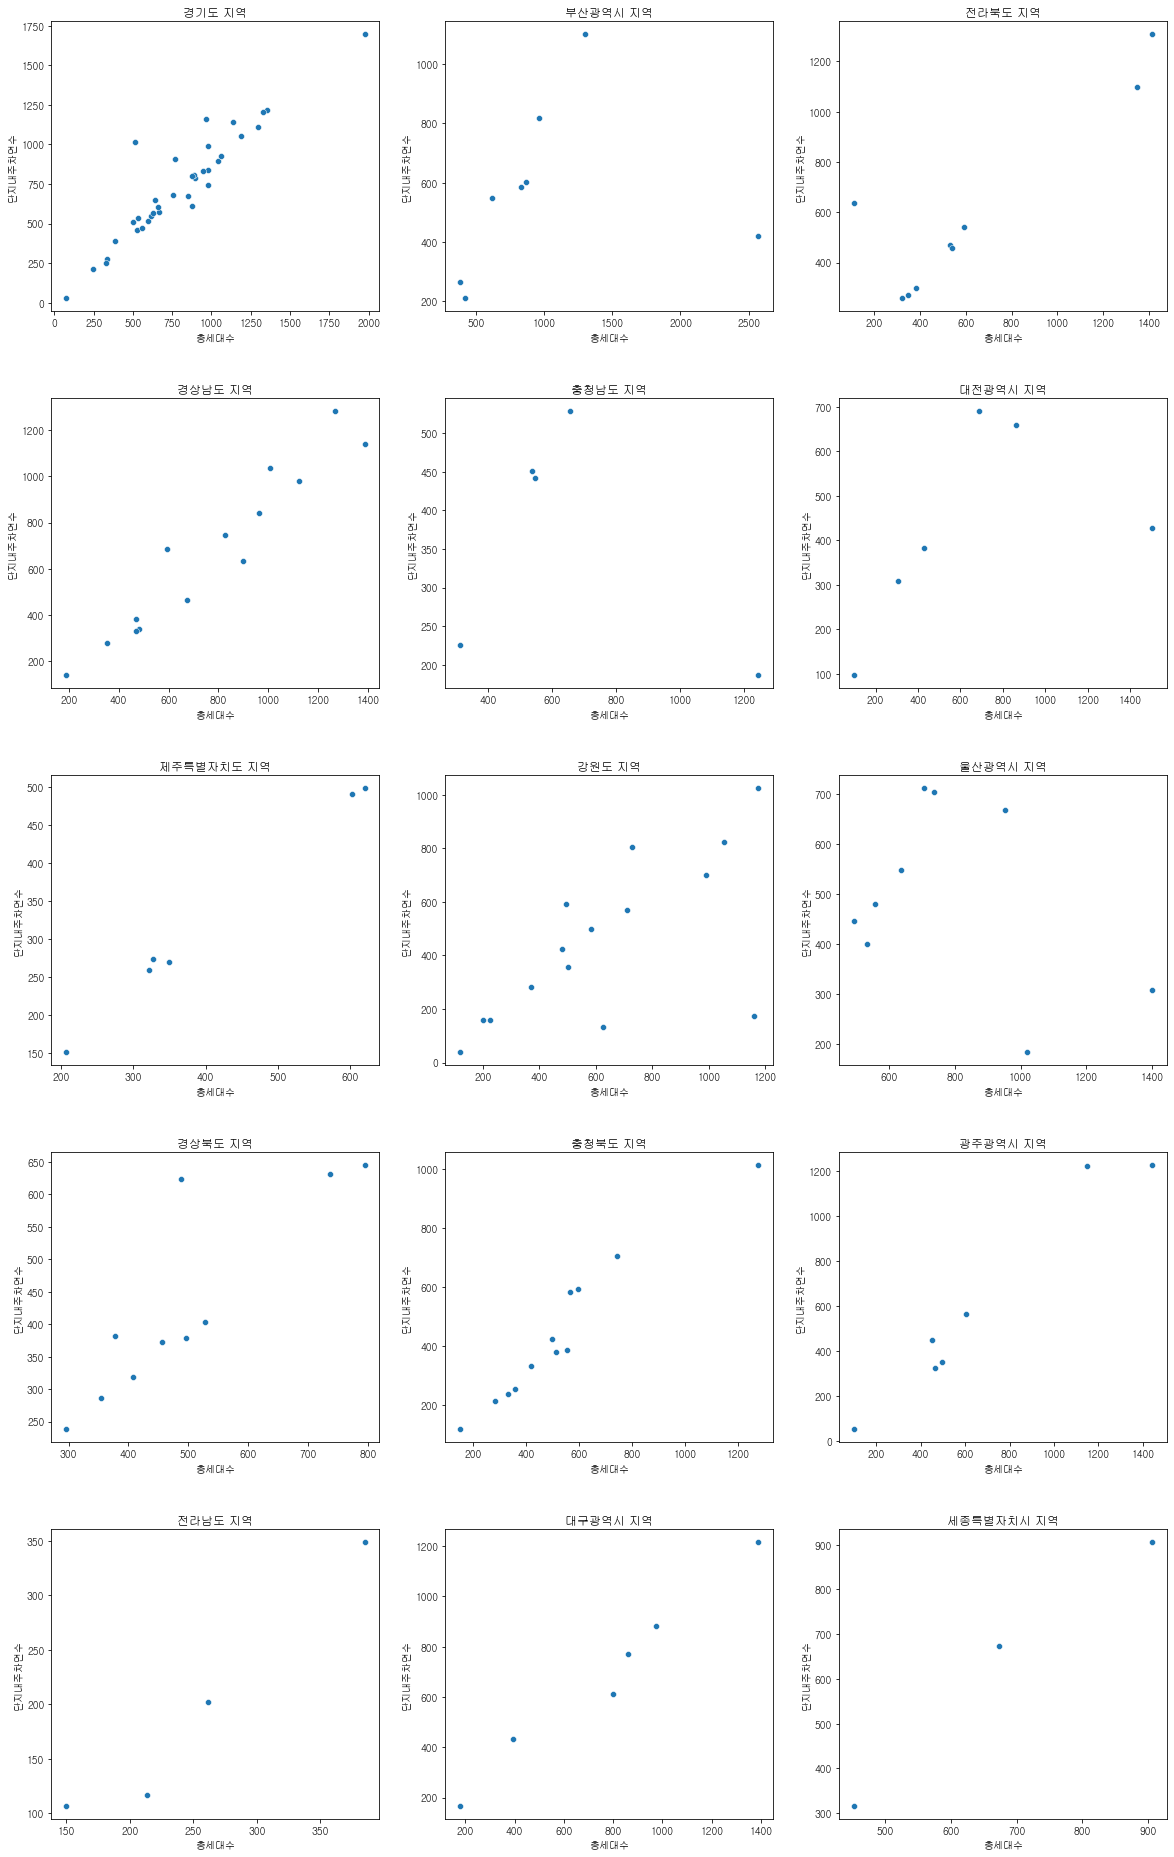

In [26]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.scatterplot(data=test_danji.loc[test_danji['지역'] == n], x='총세대수', y='단지내주차면수')
    plt.title('{} 지역'.format(n))

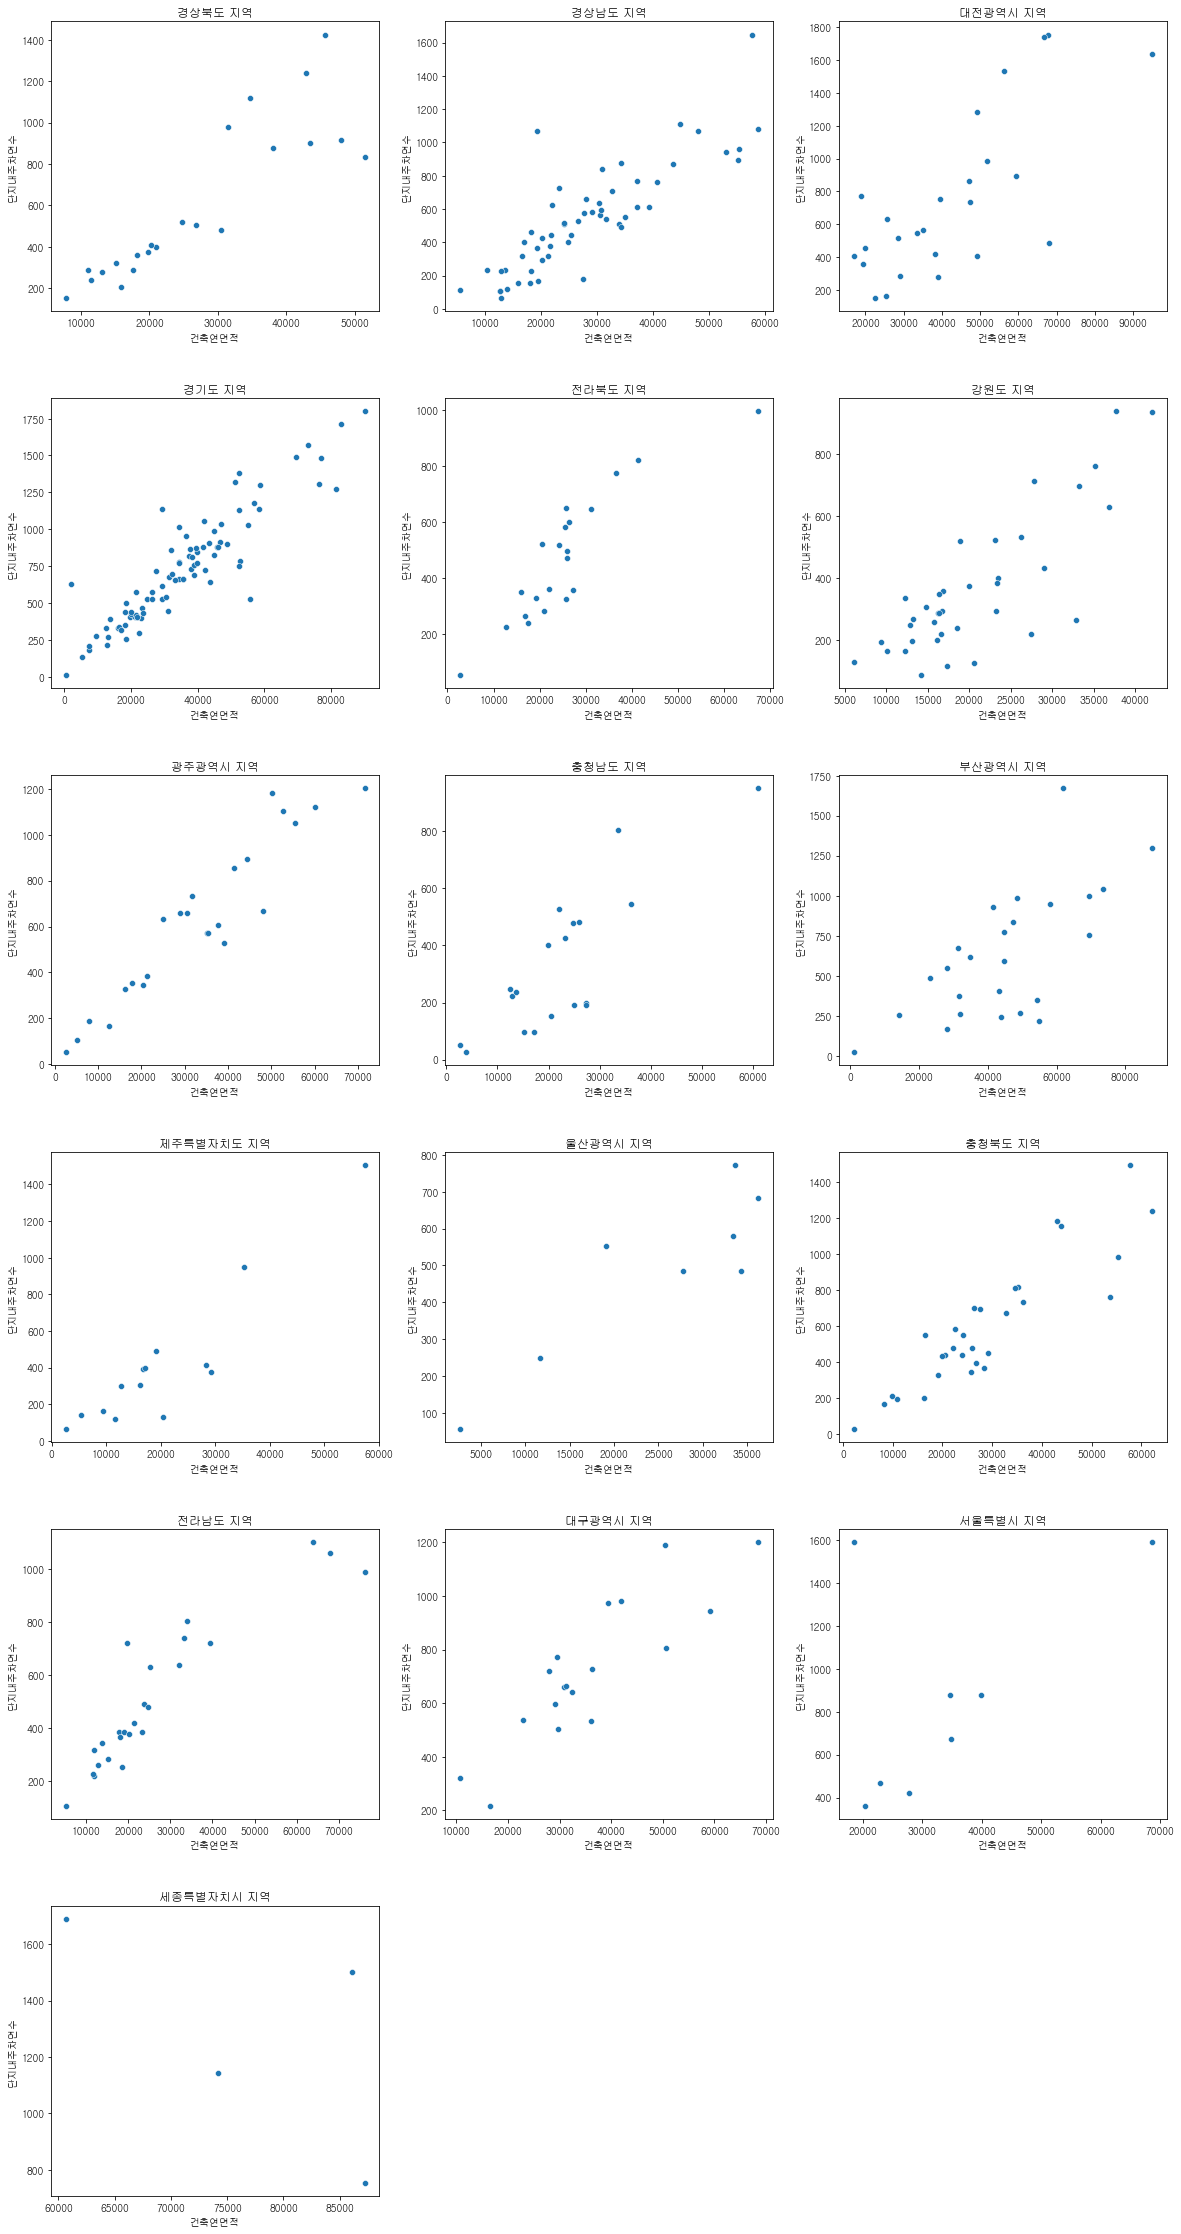

In [27]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.scatterplot(data=train_size.loc[train_size['지역'] == n], x='건축연면적', y='단지내주차면수')
    plt.title('{} 지역'.format(n))

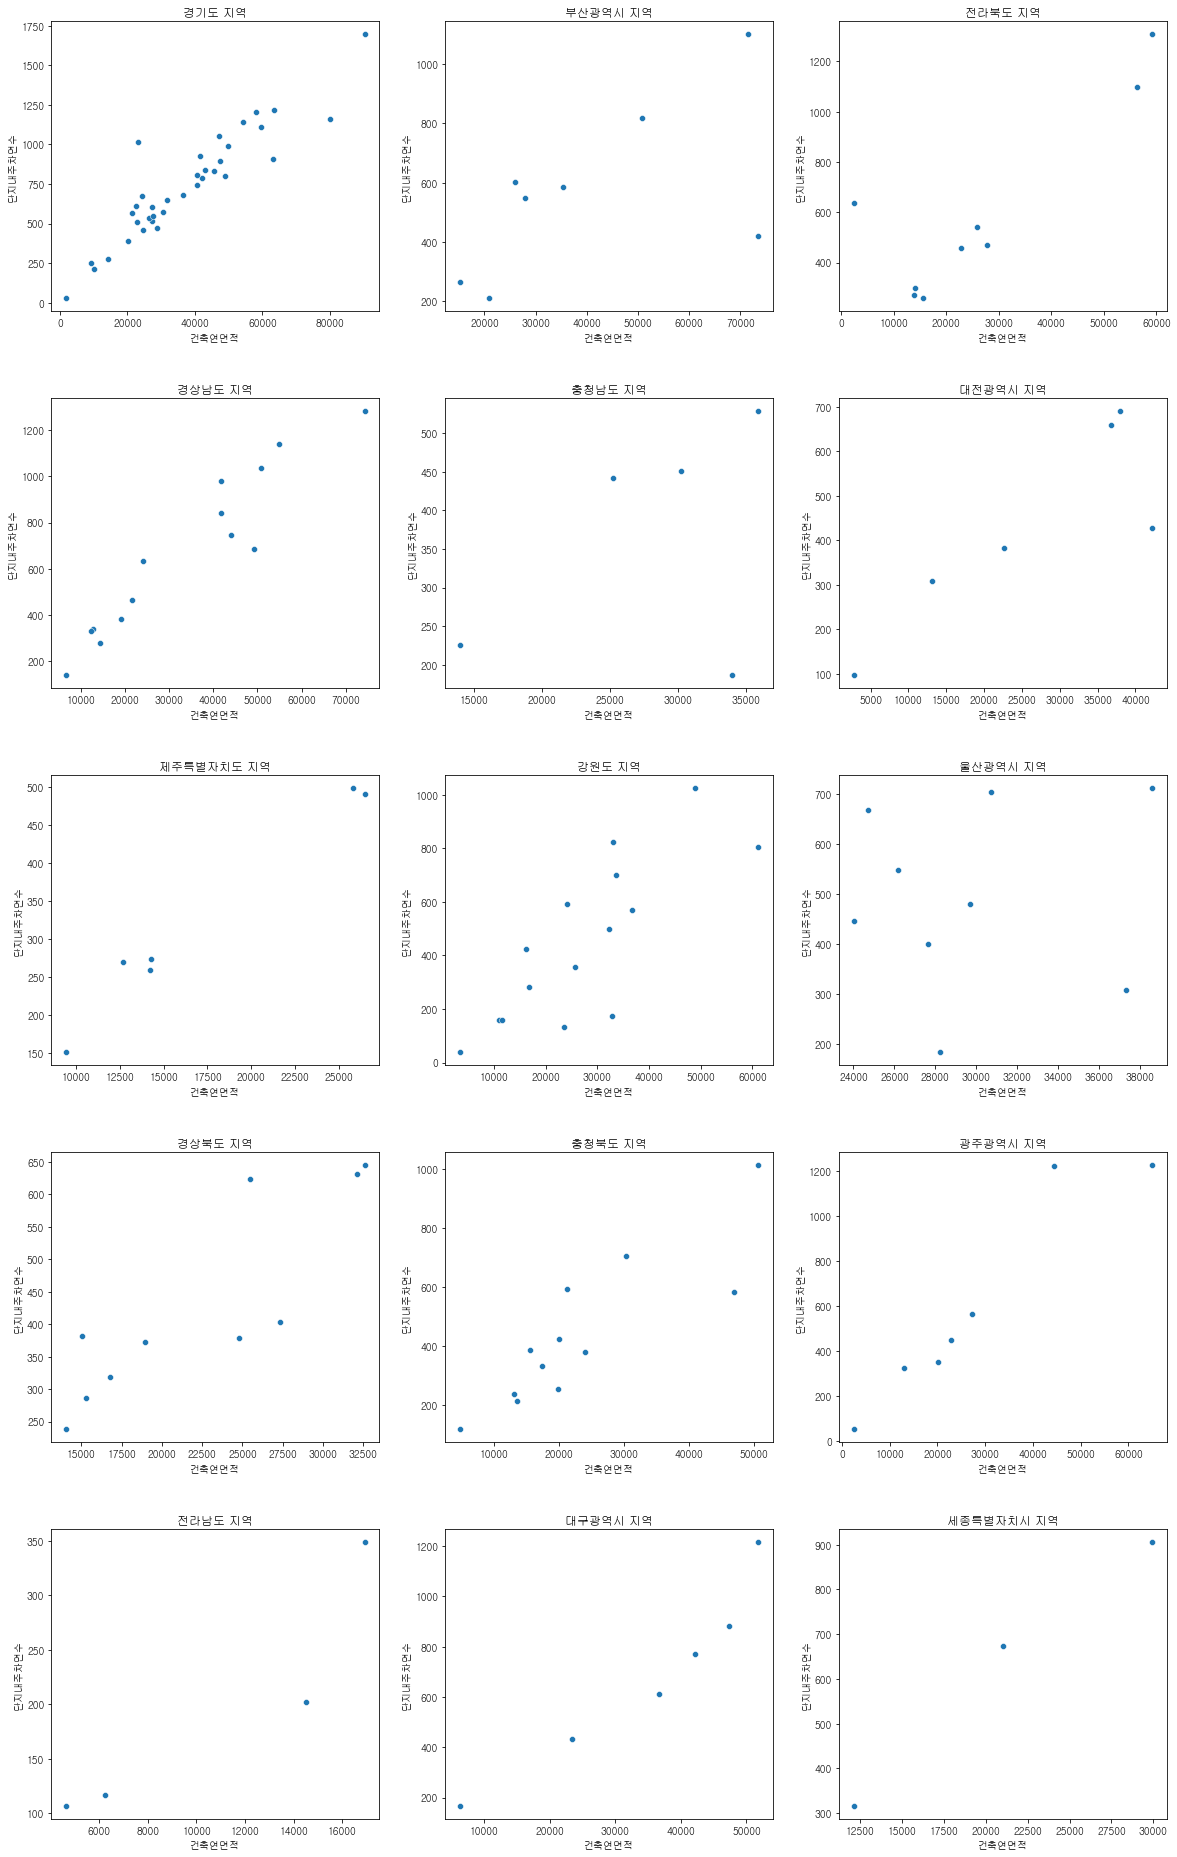

In [28]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.scatterplot(data=test_size.loc[test_size['지역'] == n], x='건축연면적', y='단지내주차면수')
    plt.title('{} 지역'.format(n))

비율을 한 번 따져보겠습니다.

In [29]:
train_size['주차면수등록차량수비'] = train_size['등록차량수'] / train_size['단지내주차면수']

In [30]:
train_size.nlargest(10, '주차면수등록차량수비')

,단지코드,총세대수,지역,공가수,지하철,버스,단지내주차면수,등록차량수,건축연면적,주차면수등록차량수비
31,C1722,809,강원도,1.0,0.0,6.0,264.0,649.0,32852.14,2.458333
97,C1026,290,경상북도,10.0,0.0,2.0,205.0,422.0,15897.70,2.058537
411,C1894,307,경기도,13.0,0.0,4.0,212.0,419.0,7499.46,1.976415
219,C1768,508,충청북도,4.0,0.0,1.0,370.0,670.0,28369.82,1.810811
320,C1743,791,대구광역시,16.0,1.0,1.0,944.0,1653.0,59167.83,1.751059
124,C2635,330,경기도,1.0,0.0,3.0,259.0,442.0,18555.90,1.706564
302,C2405,600,경상남도,22.0,0.0,8.0,728.0,1240.0,23204.68,1.703297
348,C2040,198,충청북도,11.0,0.0,2.0,200.0,336.0,16329.06,1.680000
362,C2143,363,강원도,2.0,0.0,2.0,434.0,719.0,29048.58,1.656682
295,C2620,1029,전라남도,28.0,0.0,6.0,1061.0,1709.0,67949.64,1.610745


In [31]:
train_size.nsmallest(10, '주차면수등록차량수비')

,단지코드,총세대수,지역,공가수,지하철,버스,단지내주차면수,등록차량수,건축연면적,주차면수등록차량수비
70,C2401,213,강원도,21.0,0.0,3.0,164.0,19.0,10094.12,0.115854
19,C2013,595,경상남도,3.0,0.0,3.0,509.0,91.0,24113.82,0.178782
396,C2362,1509,경기도,46.0,0.0,2.0,1055.0,196.0,41935.90,0.185782
30,C1859,2424,대전광역시,1.0,1.0,4.0,487.0,116.0,68049.09,0.238193
25,C1616,1507,대전광역시,1.0,0.0,2.0,407.0,98.0,49170.99,0.240786
14,C2576,405,경상남도,19.0,0.0,4.0,296.0,73.0,20188.66,0.246622
17,C2650,875,부산광역시,13.0,0.0,4.0,616.0,159.0,34704.24,0.258117
27,C2258,965,대전광역시,13.0,0.0,3.0,287.0,78.0,29065.37,0.271777
50,C1899,451,경상남도,0.0,0.0,4.0,109.0,31.0,12653.34,0.284404
28,C1032,946,대전광역시,6.0,1.0,2.0,986.0,316.0,51895.52,0.320487


<AxesSubplot:xlabel='주차면수등록차량수비', ylabel='Count'>

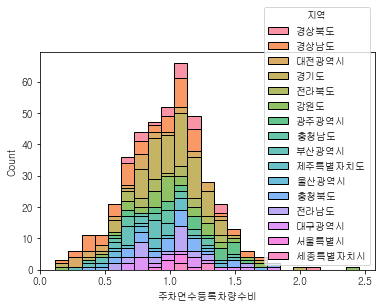

In [32]:
sns.histplot(data=train_size, x='주차면수등록차량수비', hue='지역', multiple="stack")

<AxesSubplot:xlabel='주차면수등록차량수비', ylabel='Count'>

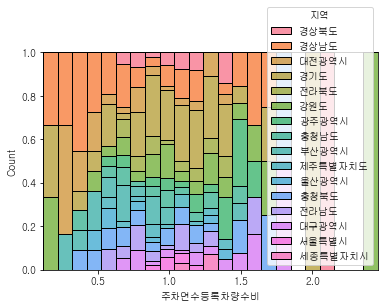

In [33]:
sns.histplot(data=train_size, x='주차면수등록차량수비', hue='지역', multiple="fill")

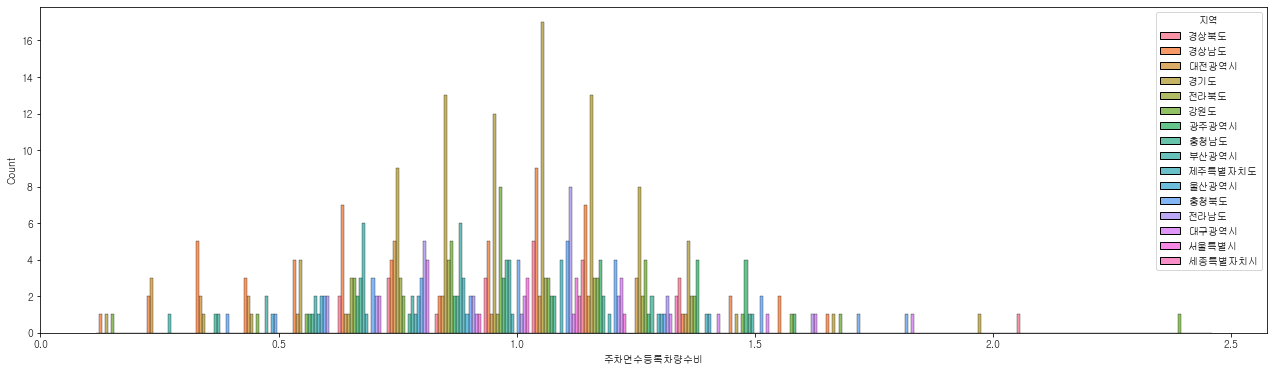

In [34]:
plt.figure(figsize=(22, 6))
sns.histplot(data=train_size, x='주차면수등록차량수비', hue='지역', multiple="dodge")
plt.show()

## VALUE PREPROCCESSING

### 총세대수, 전용면적별세대수 미일치 데이터 보간

In [32]:
train.loc[train['단지코드'] == 'C1206']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
647,C1206,755,아파트,강원도,영구임대,26.37,239,1.0,C,3141000,69900,0.0,4.0,88.0,90.0
648,C1206,755,아파트,강원도,영구임대,31.32,239,1.0,C,3731000,83020,0.0,4.0,88.0,90.0
649,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0
650,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0
651,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0
652,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0
653,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0
654,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0
655,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0
656,C1206,755,상가,강원도,임대상가,31.84,1,1.0,D,NaN,NaN,0.0,4.0,88.0,90.0


- 속초 청초 아파트, 무려 1993년에 지어진 아파트입니다. 30년이 더 되었습니다.
- 속초 청초 아파트 데이터는 조금 특이합니다. 영구임대는 478세대가 있습니다.
- 그러나 분양 세대까지 합쳐서 755 세대입니다. 여기서는 또 총 세대수를 755로 해놨습니다.
- 네이버 부동산 정보에 의하면 주차는 약 400개 입니다.
- 근데 여기는 또 주차면수가 88개라고 합니다.
- 지도를 살펴봐도 400개는 안되어보입니다. 그렇다고 88개는 또 말이 안됩니다.
- 근데 등록차량수는 또 90대 입니다.
- 알았습니다. 해당 단지는 분양세대와 임대세대까지 755호의 단지는 맞지만, 임대세대는 478세대, 그리고 임대단지 앞에 있는 주차면수는 88개가 맞습니다.
- 분양단지까지 했을 때, 주차면수는 늘어나지만, 그걸 원하는 것은 아닙니다.
- 즉, 해당 단지는 세대수를 478로 줄이는 게 맞습니다.

In [113]:
train.loc[train['공급유형'] == '공공분양']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,건축연면적
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,23755.98
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,10266.78
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,1648.68
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,13930.16
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,1613.86
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,2208.96
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,2209.22


In [114]:
test.loc[test['공급유형'] == '공공분양']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,건축연면적


In [35]:
train.loc[train['단지코드'] == 'C1350']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,건축연면적
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,23755.98
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,10266.78
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,1648.68
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,13930.16
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,1613.86
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,2208.96
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0,2209.22
2338,C1350,1401,아파트,대전광역시,공공임대(10년),51.99,106,2.0,A,28013000,408600,0.0,6.0,1636.0,2315.0,5510.94
2339,C1350,1401,아파트,대전광역시,공공임대(10년),59.91,13,2.0,A,37474000,519350,0.0,6.0,1636.0,2315.0,778.83
2340,C1350,1401,아파트,대전광역시,공공임대(10년),59.92,223,2.0,A,37385000,516130,0.0,6.0,1636.0,2315.0,13362.16


In [37]:
train.loc[train['단지코드'] == 'C2470']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,건축연면적
2580,C2470,636,아파트,대전광역시,공공임대(5년),39.90,96,1.0,A,23000000,340000,1.0,2.0,772.0,887.0,3830.40
2581,C2470,636,아파트,대전광역시,공공임대(5년),46.81,264,1.0,A,26000000,380000,1.0,2.0,772.0,887.0,12357.84
2582,C2470,636,아파트,대전광역시,공공임대(5년),59.95,46,1.0,A,32000000,480000,1.0,2.0,772.0,887.0,2757.70


In [36]:
train.loc[train['단지코드'] == 'C1350']['전용면적별세대수'].sum()

1401

In [15]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]
# 속초청초아파트
train.loc[train['단지코드'] == 'C1206', '총세대수'] = 478
# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]
train = train.append({'단지코드': 'C1804',
              '총세대수': 478,
              '임대건물구분': '아파트',
              '지역': '경기도',
              '공급유형': '공공임대(10년)',
              '전용면적': 75.78,
              '전용면적별세대수': 13,
              '공가수': 3.0,
              '자격유형': 'A',
              '임대보증금': 78957000,
              '임대료': 530130,
              '지하철': 0.0,
              '버스': 3.0,
              '단지내주차면수': 629.0,
              '등록차량수': 951.0}, ignore_index=True)
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.99, '전용면적별세대수': 72, '공가수': 1.0, '자격유형': 'A', '임대보증금': 225013300, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.95, '전용면적별세대수': 66, '공가수': 1.0, '자격유형': 'A', '임대보증금': 226278000, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.99, '전용면적별세대수': 92, '공가수': 1.0, '자격유형': 'A', '임대보증금': 230417000, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
#광주첨단H-2BL,H-3BL
train.loc[train['단지코드'] == 'C1970', '총세대수'] = 200
# 평택고덕Ca1, Ca2
train.loc[train['단지코드'] == 'C1894', '총세대수'] = 296